In [1]:
import matplotlib.pyplot as plt

from scripts import tabular_baselines

import seaborn as sns
import numpy as np

from datasets import load_openml_list, valid_dids_classification, test_dids_classification, open_cc_dids
from scripts.tabular_baselines import *
from scripts.tabular_evaluation import evaluate
from scripts.tabular_metrics import calculate_score, make_ranks_and_wins_table, make_metric_matrix
from scripts import tabular_metrics
from scripts.transformer_prediction_interface import TabPFNClassifier

/anaconda/envs/fresh311/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
from notebook_utils import *

In [3]:
%load_ext autoreload

%autoreload 2

# Datasets

In [4]:
from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


Number of datasets: 30


# Setting params

In [5]:
import os
eval_positions = [1000]
max_features = 100
bptt = 2000
base_path = os.path.join('.')
overwrite = False
#max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
#max_times = [1, 15]
max_times = [1, 15, 30, 60, 60 * 5, 60 * 15, 60*60]
metric_used = tabular_metrics.auc_metric
task_type = 'multiclass'

In [6]:
from scripts.distill_mlp import DistilledTabPFNMLP
from tabpfn.transformer_make_model import PermutationsMeta, ForwardMLPModel
from functools import partial
from scripts.tabular_baselines import knn_metric, catboost_metric, transformer_metric, logistic_metric, xgb_metric, random_forest_metric, mlp_metric


# Baseline Evaluation
This section runs baselines and saves results locally.

In [7]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/multiclass/

In [8]:
cc_test_datasets_multiclass_df['isNumeric'] = (cc_test_datasets_multiclass_df.NumberOfSymbolicFeatures == 1) & (cc_test_datasets_multiclass_df.NumberOfInstancesWithMissingValues == 0)
name_indexed_dataset = cc_test_datasets_multiclass_df.set_index("name")

#numeric_test_datasets = [ds for ds in cc_test_datasets_multiclass if name_indexed_dataset.loc[ds[0]].isNumeric]
len(name_indexed_dataset)

30

In [267]:
from tabpfn.scripts.model_builder import load_model
bla = load_model(mothernet_21_46_25_3940_ensemble3.base_estimator.path,'cpu')

In [278]:
sum(p.numel() for p in bla[0].decoder.parameters())/1000/1000

124.370058

In [279]:
bla[1]

{'lr': 3e-05,
 'dropout': 0.0,
 'emsize': 512,
 'batch_size': 8,
 'nlayers': 12,
 'num_features': 100,
 'nhead': 4,
 'nhid_factor': 2,
 'bptt': 1152,
 'eval_positions': None,
 'seq_len_used': 50,
 'sampling': 'normal',
 'epochs': 4000,
 'num_steps': 8192,
 'verbose': False,
 'mix_activations': False,
 'pre_sample_causes': True,
 'multiclass_type': 'rank',
 'nan_prob_unknown_reason_reason_prior': 0.5,
 'categorical_feature_p': 0.2,
 'nan_prob_no_reason': 0.0,
 'nan_prob_unknown_reason': 0.0,
 'nan_prob_a_reason': 0.0,
 'max_num_classes': 10,
 'noise_type': 'Gaussian',
 'balanced': False,
 'normalize_to_ranking': False,
 'set_value_to_nan': 0.1,
 'normalize_by_used_features': True,
 'num_categorical_features_sampler_a': -1.0,
 'differentiable_hyperparameters': {'prior_bag_exp_weights_1': {'distribution': 'uniform',
   'min': 2.0,
   'max': 10.0},
  'num_layers': {'distribution': 'meta_gamma',
   'max_alpha': 2,
   'max_scale': 3,
   'round': True,
   'lower_bound': 2},
  'prior_mlp_hidde

In [10]:
import os
os.environ["LD_LIBRARY_PATH"] = "/anaconda/envs/fresh311/lib:" + os.environ["LD_LIBRARY_PATH"]

In [11]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
max_times = [1, 5, 15, 60, 5 * 60, 15 * 60, 60* 60]
# these will all be evaluated on CPU because they are given as  callables, which is a weird way to do it.
clf_dict= {
    'knn': knn_metric,
    'rf_new_params': random_forest_metric,
    'xgb': xgb_metric,
    'logistic': logistic_metric,
    'mlp': mlp_metric}

results_baselines = [
    eval_on_datasets('multiclass', model, model_name, cc_test_datasets_multiclass, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     bptt=bptt, base_path=base_path)
    for model_name, model in clf_dict.items()
]

evaluating knn on cpu


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
/anaconda/envs/fresh311/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/anaconda/envs/fresh311/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorc

evaluating rf_new_params on cpu


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating xgb on cpu


[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating logistic on cpu


[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 859 out of 1050 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating mlp on cpu


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 859 out of 1050 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    0.6s finished


In [141]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from tabpfn.transformer_make_model import ShiftClassifier, EnsembleMeta, ForwardMLPModel

# transformers don't have max times
import warnings
max_times = [1]
device = "cpu"

model_string = "defaults_k_aggregate_2_batch_128_onehot_classes_multiclass_02_10_2023_23_55_16"
tabpfn_mine =  TabPFNClassifier(device=device, model_string=model_string, epoch=82, N_ensemble_configurations=32)
#tabpfn_refactor = TabPFNClassifier(device=device, model_string="vanilla_lr0001_new_05_31_2023_23_16_43", epoch=200, N_ensemble_configurations=32)
#tabpfn_refactor_epoch_290 = TabPFNClassifier(device=device, model_string="vanilla_lr0001_new_05_31_2023_23_16_43", epoch=290, N_ensemble_configurations=32)

distilled_tabpfn = DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, )
distilled_tabpfn_one_layer = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=1, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_one_layer_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=1, dropout_rate=0, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_reproduce2 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_one_layer_512_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=512, n_layers=1, learning_rate=0.001, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_512_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=512, n_layers=2, learning_rate=0.001, model_string=model_string, epoch=82, ))

distilled_tabpfn_two_layer_reproduce_gpu = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, N_ensemble_configurations=3))
distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device="cpu", hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, N_ensemble_configurations=3))
new_model_string = "tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33"
distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device="cpu", hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=new_model_string, epoch=1650, N_ensemble_configurations=3))

mother_model_string = "models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_65.cpkt"
forward_mlp = PermutationsMeta(ForwardMLPModel(path=mother_model_string, device=device))
mothernet_new = PermutationsMeta(ForwardMLPModel(path='models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_on_exit.cpkt'))
mothernet_new_again = PermutationsMeta(ForwardMLPModel(path='models_diff/mothernet_from_scratch_again_06_28_2023_20_51_25_epoch_on_exit.cpkt'))

mothernet_big_model_string = "models_diff/prior_diff_real_checkpointwarm_start_depth_18_model_maker_lr0003_multiclass_05_30_2023_22_53_04_n_0_epoch_49.cpkt"
mothernet_big = PermutationsMeta(ForwardMLPModel(path=mothernet_big_model_string, device=device))

model_string_post_refactor = "models_diff/prior_diff_real_checkpointmothernet_from_scratch_lr0003_warm_start_continue2_multiclass_05_31_2023_19_21_34_n_0_epoch_94.cpkt"
mothernet_post_refactor = PermutationsMeta(ForwardMLPModel(path=model_string_post_refactor, device=device))

model_string_mothernet_small_batches = "models_diff/mothernet_512_everywhere_steps_1024_batch_16_07_02_2023_17_29_55_epoch_on_exit.cpkt"
mothernet_small_batches = PermutationsMeta(ForwardMLPModel(path=model_string_mothernet_small_batches, device=device))


model_string_old_reference_config = "reproduce_reference_config_06_02_2023_17_08_59"
old_reference_config = TabPFNClassifier(device=device, model_string=model_string_old_reference_config, epoch="on_exit", N_ensemble_configurations=32)
old_reference_config_epoch_290 = TabPFNClassifier(device=device, model_string=model_string_old_reference_config, epoch=290, N_ensemble_configurations=32)

model_string_reference_config_continue =  "reproduce_reference_config_continue_06_05_2023_17_45_06"
reference_config_continue = TabPFNClassifier(device=device, model_string=model_string_reference_config_continue, epoch="on_exit", N_ensemble_configurations=32)



model_string_reference_config_long = "reproduce_reference_config_try_again_800_epochs_06_07_2023_21_49_10"
reference_config_long = TabPFNClassifier(device=device, model_string=model_string_reference_config_long, epoch="on_exit", N_ensemble_configurations=32)

perceiver_long = ForwardMLPModel(path="models_diff/perceiver_output_128_emsize_512_nlayers_12_steps_1024_07_01_2023_17_56_04_epoch_690.cpkt", device=device)
perceiver_long_permutations = PermutationsMeta(perceiver_long)

model_string_newest_mlflow = "models_diff/mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38_epoch_1350.cpkt"
mothernet_mlflow_04_54_38 = PermutationsMeta(ForwardMLPModel(path=model_string_newest_mlflow, device=device))

model_string_newest_mlflow_1750 = "models_diff/mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38_epoch_1750.cpkt"
mothernet_mlflow_04_54_38_e1750 = PermutationsMeta(ForwardMLPModel(path=model_string_newest_mlflow_1750, device=device))
mothernet_mlflow_04_54_38_e1750_ensemble = EnsembleMeta(ForwardMLPModel(path=model_string_newest_mlflow_1750, device=device))


#mothernet_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38", epoch="1350", N_ensemble_configurations=32)

mothernet_new_old_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0", epoch="on_exit", N_ensemble_configurations=32)
mothernet_new_old_ensemble =  EnsembleMeta(ForwardMLPModel(device=device, path="models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_on_exit.cpkt"), n_estimators=32)

#mothernet_1750_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38", epoch="1750", N_ensemble_configurations=32)


perceiver_16_19_18_ensemble =  EnsembleMeta(ForwardMLPModel(device=device, path="models_diff/perceiver_128_emsize_512_nlayers_12_steps_4096_batch_64_lr_3e-05_one_gpu_07_11_2023_16_19_18_epoch_1120.cpkt"), n_estimators=32)

mlflow_validate_str = "tabpfn_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_8ada_lr_3e-05_1_gpu_07_21_2023_21_58_32"
mlflow_validate_tabpfn = TabPFNClassifier(device=device, model_string=mlflow_validate_str, epoch="1470", N_ensemble_configurations=32)

#mother_of_ensembles = BaggingClassifier(PermutationsMeta(ForwardMLPModel(path=mother_model_string)), max_features=.8, max_samples=.8)
#mother_of_ensembles_again = BaggingClassifier(PermutationsMeta(ForwardMLPModel(path=mother_model_string)), max_features=.5, max_samples=.5)
forward_mlp_scaled = make_pipeline(StandardScaler(), forward_mlp)
distilled_tabpfn_scaled = make_pipeline(StandardScaler(), distilled_tabpfn)


new_tabpfn_long_e1020 = TabPFNClassifier(device=device, model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1020", N_ensemble_configurations=32)
new_tabpfn_long_e1650_ensemble32 = TabPFNClassifier(device=device, model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1650", N_ensemble_configurations=32)
new_tabpfn_long_e1650_ensemble3 = TabPFNClassifier(device=device, model_string="tabpfn_nooptimizer_emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1650", N_ensemble_configurations=3)


# large batchsize large learning rate
mothernet_old_config_repro_20_10_21_ensemble = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_512_bs_8192_lr_0.0003_1_gpu_07_28_2023_20_10_21_epoch_2000.cpkt", device=device))
# small batchsize small learning rate
mothernet_new_config_04_14_37_ensemble_e1390 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_epoch_1390.cpkt", device=device)) 
mothernet_new_config_04_14_37_ensemble_e1520 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_epoch_1520.cpkt", device=device)) 

mothernet_01_07_16_e1560 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1560.cpkt", device=device))
mothernet_21_29_51_e5610 = EnsembleMeta(ForwardMLPModel(path="models_diff/mn_n1024_E8000_1_gpu_08_01_2023_21_29_51_epoch_5610.cpkt", device=device))

low_rank_48_19 = EnsembleMeta(ForwardMLPModel(path="models_diff/mn_n1024_L2_W128_P512_1_gpu_08_03_2023_03_48_19_epoch_on_exit.cpkt", device=device))
mothernet_L2_18_33_e780 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_31_2023_23_18_33_epoch_780.cpkt", device=device))

mothernet_15_46_11_e120 =  EnsembleMeta(ForwardMLPModel(path="models_diff/mn_d1024_H2048_l1e-06_b32_noprenormTrue_1_gpu_warm_08_13_2023_15_46_11_epoch_130.cpkt", device=device))
tabpfn_21_43_17_e760 =  TabPFNClassifier(model_string="tabpfn_n512_l1e-05_b32_mtabpfn_noprenormTrue_1_gpu_warm_08_11_2023_21_43_17", device=device, epoch=760, N_ensemble_configurations=32)
mothernet_01_07_16_e1720 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device))
mothernet_01_07_16_e1720_gpu = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device))
mothernet_01_07_16_e1720_gpu_ensemble3 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device), n_estimators=3)
mothernet_01_07_16_e1720_cpu_ensemble3 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device="cpu"), n_estimators=3)
mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device, inference_device=device), n_estimators=3)
mothernet_05_25_46_e5900 = EnsembleMeta(ForwardMLPModel(path="models_diff/mn_n1024_E8000_d2048_H4096_L2_W128_P512_1_gpu_08_06_2023_05_25_46_epoch_5900.cpkt", device=device))
mothernet_L2_W128_05_25_46_e6550 = EnsembleMeta(ForwardMLPModel(path="models_diff/mn_n1024_E8000_d2048_H4096_L2_W128_P512_1_gpu_08_06_2023_05_25_46_epoch_6550.cpkt", device=device))

mothernet_21_46_25_3940_ensemble3 = EnsembleMeta(ForwardMLPModel(path="mn_d2048_H4096_L2_W32_P512_1_gpu_warm_08_25_2023_21_46_25_epoch_3940_no_optimizer.pickle", device=device), n_estimators=3)


# actually accidentally trained with false due to bug, even if config says true
#reference_config_long.model.efficient_eval_masking = False
clf_dict= {
    
             'transformer': transformer_metric,
            'transformer_gpu_timing': TabPFNClassifier(device=device, N_ensemble_configurations=3),
              # 'tabpfn_mine': partial(transformer_metric, classifier=tabpfn_mine),
             #  'tabpfn_post_mlflow': partial(transformer_metric, classifier=mlflow_validate_tabpfn),
          
        'mothernet_01_07_16_e1720_cpu_ensemble3_prescaling': mothernet_01_07_16_e1720_cpu_ensemble3,
    'new_tabpfn_long_e1650_ensemble32': new_tabpfn_long_e1650_ensemble32,
    'new_tabpfn_long_e1650_ensemble3': new_tabpfn_long_e1650_ensemble3,

    'distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed': distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3,
    'mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference_fixed': mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference,
      #  'mothernet_05_25_46_e5900': partial(transformer_metric, classifier=mothernet_05_25_46_e5900),
    #'distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3': distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3,
    #'mothernet_L2_W128_05_25_46_e6550': mothernet_L2_W128_05_25_46_e6550
      #  'mothernet_21_46_25_3940_ensemble3_onehot': partial(transformer_metric, classifier=mothernet_21_46_25_3940_ensemble3, onehot=True),
        'mothernet_21_46_25_3940_ensemble3': partial(transformer_metric, classifier=mothernet_21_46_25_3940_ensemble3),
    'new_tabpfn_long_e1650_ensemble3_onehot': partial(transformer_metric, classifier=new_tabpfn_long_e1650_ensemble3, onehot=True),
        'mothernet_21_46_25_3940_ensemble3_onehot': partial(transformer_metric, classifier=mothernet_21_46_25_3940_ensemble3, onehot=True),
        'distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed_redo': distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3,


                  }
results_transformers = [
    eval_on_datasets('multiclass', model, model_name, cc_test_datasets_multiclass, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     bptt=bptt, base_path=base_path, overwrite=False, n_jobs=1)
    for model_name, model in clf_dict.items()
]

evaluating transformer on cpu


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


evaluating transformer_gpu_timing on cpu


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


evaluating mothernet_01_07_16_e1720_cpu_ensemble3_prescaling on cpu


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


evaluating new_tabpfn_long_e1650_ensemble32 on cpu


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


evaluating new_tabpfn_long_e1650_ensemble3 on cpu


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


evaluating distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed on cpu


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


evaluating mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference_fixed on cpu


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


evaluating mothernet_21_46_25_3940_ensemble3 on cpu


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


evaluating new_tabpfn_long_e1650_ensemble3_onehot on cpu


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


evaluating mothernet_21_46_25_3940_ensemble3_onehot on cpu


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


evaluating distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed_redo on cpu


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.0s finished


In [142]:
# results_baselines = []

In [244]:
flat_results = []
for per_dataset in results_baselines + results_transformers:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        best_configs_key, = [k for k in result.keys() if "best_configs" in k]
        if result[best_configs_key][0] is not None:
            row.update(result[best_configs_key][0])
        row['mean_metric'] = float(row["mean_metric"].numpy())
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [245]:
results_df

,dataset,model,mean_metric,split,max_time,best,fit_time,inference_time
0,balance-scale,knn,0.898451,1,1,{'n_neighbors': 14},0.000790,0.031152
1,balance-scale,knn,0.848925,2,1,{'n_neighbors': 8},0.000795,0.026842
2,balance-scale,knn,0.852651,3,1,{'n_neighbors': 10},0.000851,0.027301
3,balance-scale,knn,0.885874,4,1,{'n_neighbors': 10},0.000786,0.028868
4,balance-scale,knn,0.895205,5,1,{'n_neighbors': 15},0.000829,0.027410
...,...,...,...,...,...,...,...,...
6895,climate-model-simulation-crashes,distilled_tabpfn_two_layer_reproduce_gpu_ensem...,0.886769,1,1,NaN,14.900065,0.002607
6896,climate-model-simulation-crashes,distilled_tabpfn_two_layer_reproduce_gpu_ensem...,0.899927,2,1,NaN,11.701487,0.002500
6897,climate-model-simulation-crashes,distilled_tabpfn_two_layer_reproduce_gpu_ensem...,0.898967,3,1,NaN,11.068054,0.002017
6898,climate-model-simulation-crashes,distilled_tabpfn_two_layer_reproduce_gpu_ensem...,0.902608,4,1,NaN,11.672800,0.001892


In [246]:
def remove_device_from_frame(df):    
    res = df.copy()
    res = res[~res.model.str.contains("CPU")]
    res['model'] = res['model'].str.replace(" GPU", "")
    return res

In [247]:
import pickle
with open("results_test_post_refactor.pickle", "wb") as f:
    pickle.dump(results_baselines + results_transformers, f)

In [248]:
results_df.to_csv("results_test_post_refactor.csv")

In [300]:
results_df['model'] = results_df.model.replace({'knn': "KNN", 'rf_new_params': 'RF', 'mlp': "MLP", 'transformer_gpu_timing': 'TabPFN (Hollmann)', 'transformer': "transformer_org",'distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed': 'MLP-Distill GPU', 'xgb':'XGBoost', 'logistic': 'LogReg', 'distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3':'MLP-Distill CPU', 'mothernet_21_46_25_3940_ensemble3_onehot': 'MotherNet', 'new_tabpfn_long_e1650_ensemble3_onehot': 'TabPFN (ours)'})
results_df = results_df[~(results_df.model.str.contains("_"))]

/tmp/ipykernel_4077616/4096823899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['model'] = results_df.model.replace({'knn': "KNN", 'rf_new_params': 'RF', 'mlp': "MLP", 'transformer_gpu_timing': 'TabPFN (Hollmann)', 'transformer': "transformer_org",'distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed': 'MLP-Distill GPU', 'xgb':'XGBoost', 'logistic': 'LogReg', 'distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3':'MLP-Distill CPU', 'mothernet_21_46_25_3940_ensemble3_onehot': 'MotherNet', 'new_tabpfn_long_e1650_ensemble3_onehot': 'TabPFN (ours)'})


In [301]:
results_df.groupby("model").inference_time.median()

model
KNN                  0.004362
LogReg               0.000327
MLP                  0.000925
MLP-Distill GPU      0.001371
MotherNet            0.032451
RF                   0.034911
TabPFN (Hollmann)    0.332275
TabPFN (ours)        3.232159
XGBoost              0.012813
Name: inference_time, dtype: float64

In [302]:
results_df.to_csv("results_test.csv")

In [303]:
legend_off = True

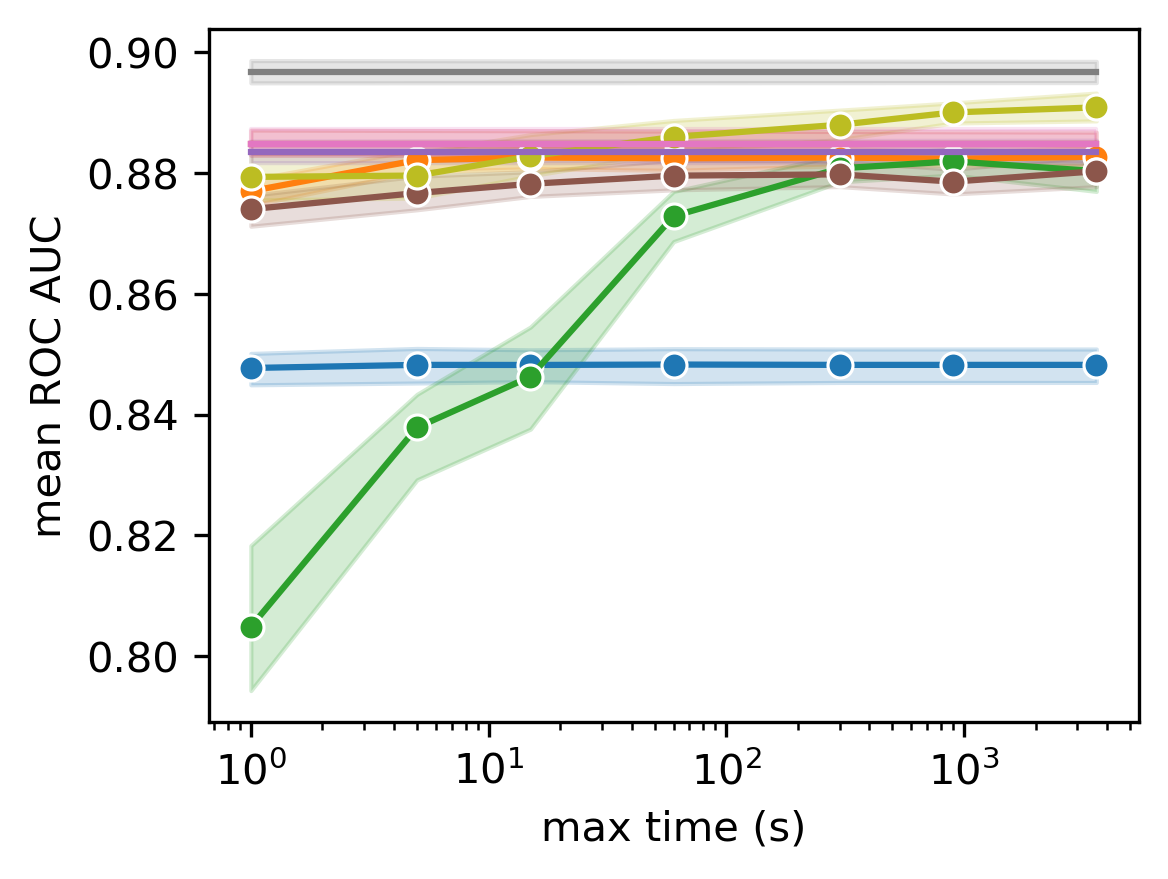

In [317]:
plt.figure(figsize=(4, 3), dpi=300)

compare_splits = remove_device_from_frame(results_df.groupby(["model", "split", "max_time"])['mean_metric'].mean().reset_index())

import seaborn as sns
varies_over_time = ['XGBoost', 'RF', 'MLP', 'KNN', 'LogReg']
compare_splits_varies = compare_splits[compare_splits.model.isin(varies_over_time)]
compare_splits_fixed = compare_splits[~compare_splits.model.isin(varies_over_time)]
all_models = compare_splits.model.unique()
color_palette = sns.color_palette(n_colors=len(all_models))
color_mapping = dict(zip(all_models, color_palette))

ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model",  marker="o", palette=color_mapping)

compare_splits_fixed_dummy = compare_splits_fixed.copy()
compare_splits_fixed_dummy['max_time'] = compare_splits_varies.max_time.max()
sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
              x="max_time", y="mean_metric", hue="model", ax=ax, palette=color_mapping)
plt.xscale("log")
#legend = plt.legend(loc=(1.1 , .3))
legend = ax.get_legend()
legend.remove()
#ax.set_ylim(0.85, 0.90)
ax.set_ylabel("mean ROC AUC")
ax.set_xlabel("max time (s)")
plt.savefig("figures/mean_auc_over_time_test.pdf", bbox_inches="tight")

In [305]:
compare_splits_varies_last = compare_splits_varies[compare_splits_varies.max_time == compare_splits_varies.max_time.max()]

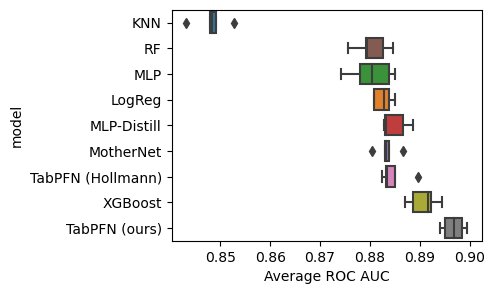

In [315]:
plt.figure(figsize=(4, 3))

order = pd.concat([compare_splits_fixed, compare_splits_varies_last]).groupby("model").median("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=pd.concat([compare_splits_fixed, compare_splits_varies_last]), y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
plt.xlabel("Average ROC AUC")
plt.savefig("figures/mean_roc_auc_test.pdf", dpi=300, bbox_inches="tight")

In [307]:
average_over_splits = results_df.groupby(["dataset", "model", "max_time"])[["mean_metric", "fit_time", "inference_time"]].mean().reset_index()

In [308]:
best_tuned = average_over_splits[average_over_splits.max_time == average_over_splits.max_time.max()]
untuned = average_over_splits[~average_over_splits.model.isin(best_tuned.model.unique())]
combined_best = pd.concat([best_tuned, untuned])

In [309]:
combined_best

,dataset,model,max_time,mean_metric,fit_time,inference_time
6,MiceProtein,KNN,3600,0.997160,0.000310,0.003859
13,MiceProtein,LogReg,3600,0.999254,0.750899,0.000371
20,MiceProtein,MLP,3600,0.999715,9.829015,0.002590
29,MiceProtein,RF,3600,0.999188,0.233837,0.027046
38,MiceProtein,XGBoost,3600,0.999776,14.160225,0.057572
...,...,...,...,...,...,...
1123,vehicle,TabPFN (ours),1,0.962531,0.000442,3.236142
1152,wdbc,MLP-Distill GPU,1,0.994813,3.091072,0.000713
1153,wdbc,MotherNet,1,0.996144,8.074254,0.020498
1161,wdbc,TabPFN (Hollmann),1,0.996465,0.000261,0.171985


/anaconda/envs/fresh311/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


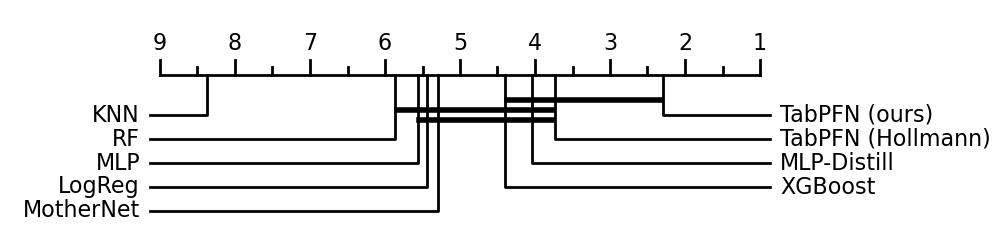

In [316]:
from tabpfn.scripts.critical_differences import draw_cd_diagram
res = draw_cd_diagram(remove_device_from_frame(combined_best), dataset_column="dataset", classifier_column="model", metric_column="mean_metric");
plt.savefig("figures/cd_diagram_test.pdf", bbox_inches="tight", pad_inches=.15)

In [311]:
results_for_ranking = results_df.pivot(index="max_time", columns=["dataset", "split", "model"], values="mean_metric").ffill()

ranks_per_split_per_dataset = results_for_ranking.stack("model").unstack("max_time").rank(ascending=False)
average_ranks = ranks_per_split_per_dataset.stack("dataset").unstack("model").mean().reset_index(name="mean_rank")

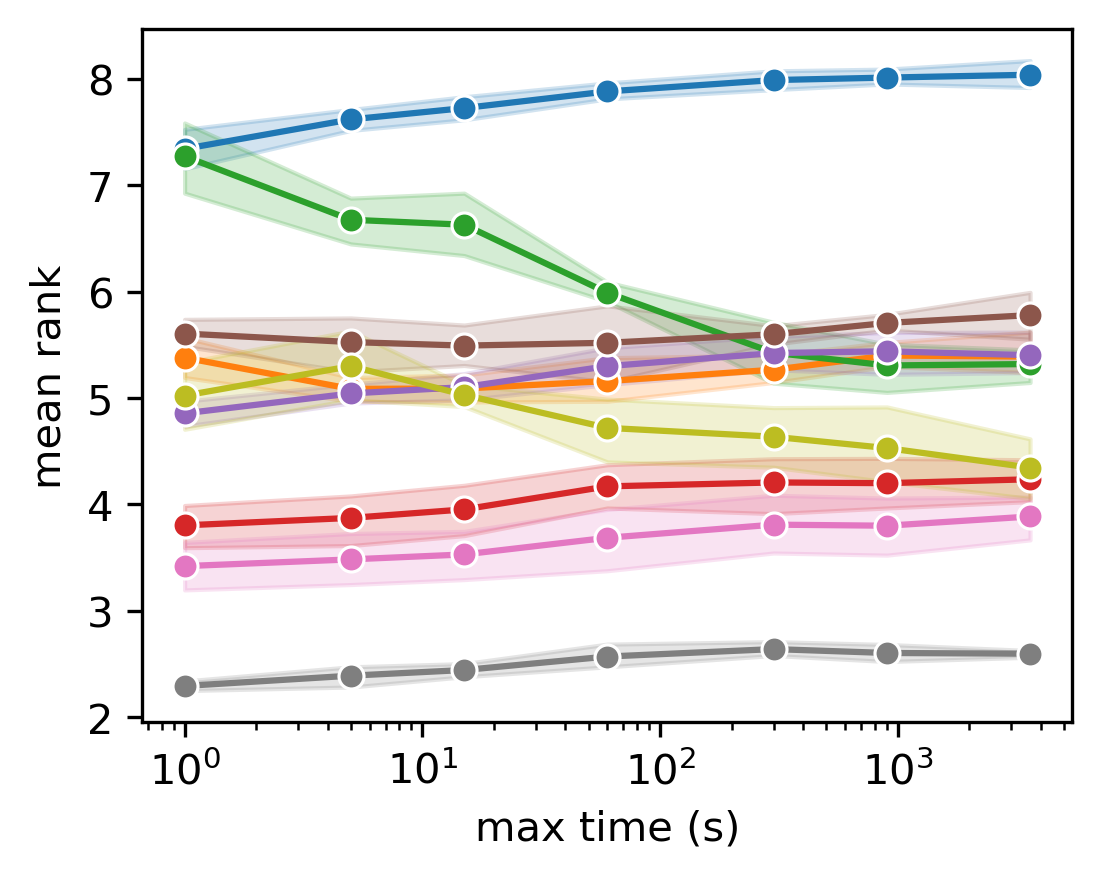

In [318]:
# ax = sns.lineplot(data=average_ranks, x="max_time", y="mean_rank", hue="model", errorbar="sd", marker="o")
plt.figure(figsize=(4, 3), dpi=300)
ax = sns.lineplot(data=remove_device_from_frame(average_ranks), x="max_time", y="mean_rank", hue="model", marker="o", palette=color_mapping)
ax.set_xscale("log")
#sns.move_legend(ax, (1.01, 0))
ax.set_ylabel("mean rank")
ax.set_xlabel("max time (s)")
legend = plt.legend(loc=(1.1 , .3))
legend.remove()
plt.savefig("figures/rank_over_time_test.pdf", bbox_inches="tight")

/tmp/ipykernel_4077616/680885952.py:3: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  ax.legend(legend.legendHandles, [t.get_text() for t in legend.texts], ncol=9)


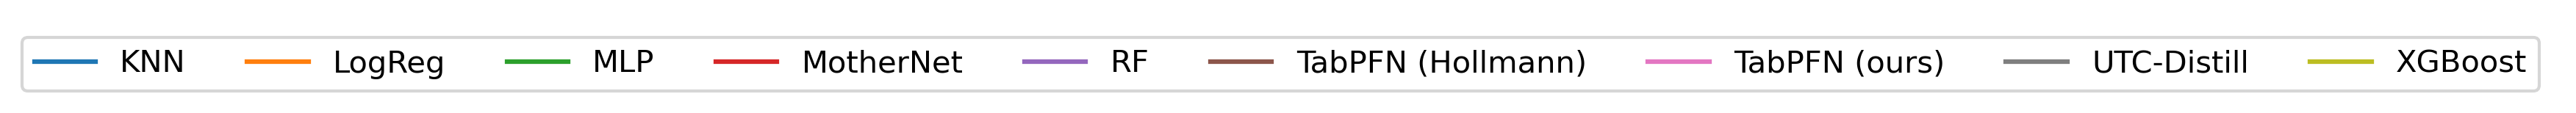

In [242]:
plt.figure(figsize=(10, .2), dpi=300)
ax = plt.gca()
ax.legend(legend.legendHandles, [t.get_text() for t in legend.texts], ncol=9)
ax.set_axis_off()
plt.savefig("figures/legend.pdf", bbox_inches="tight")

NameError: name 'with_tuning' is not defined

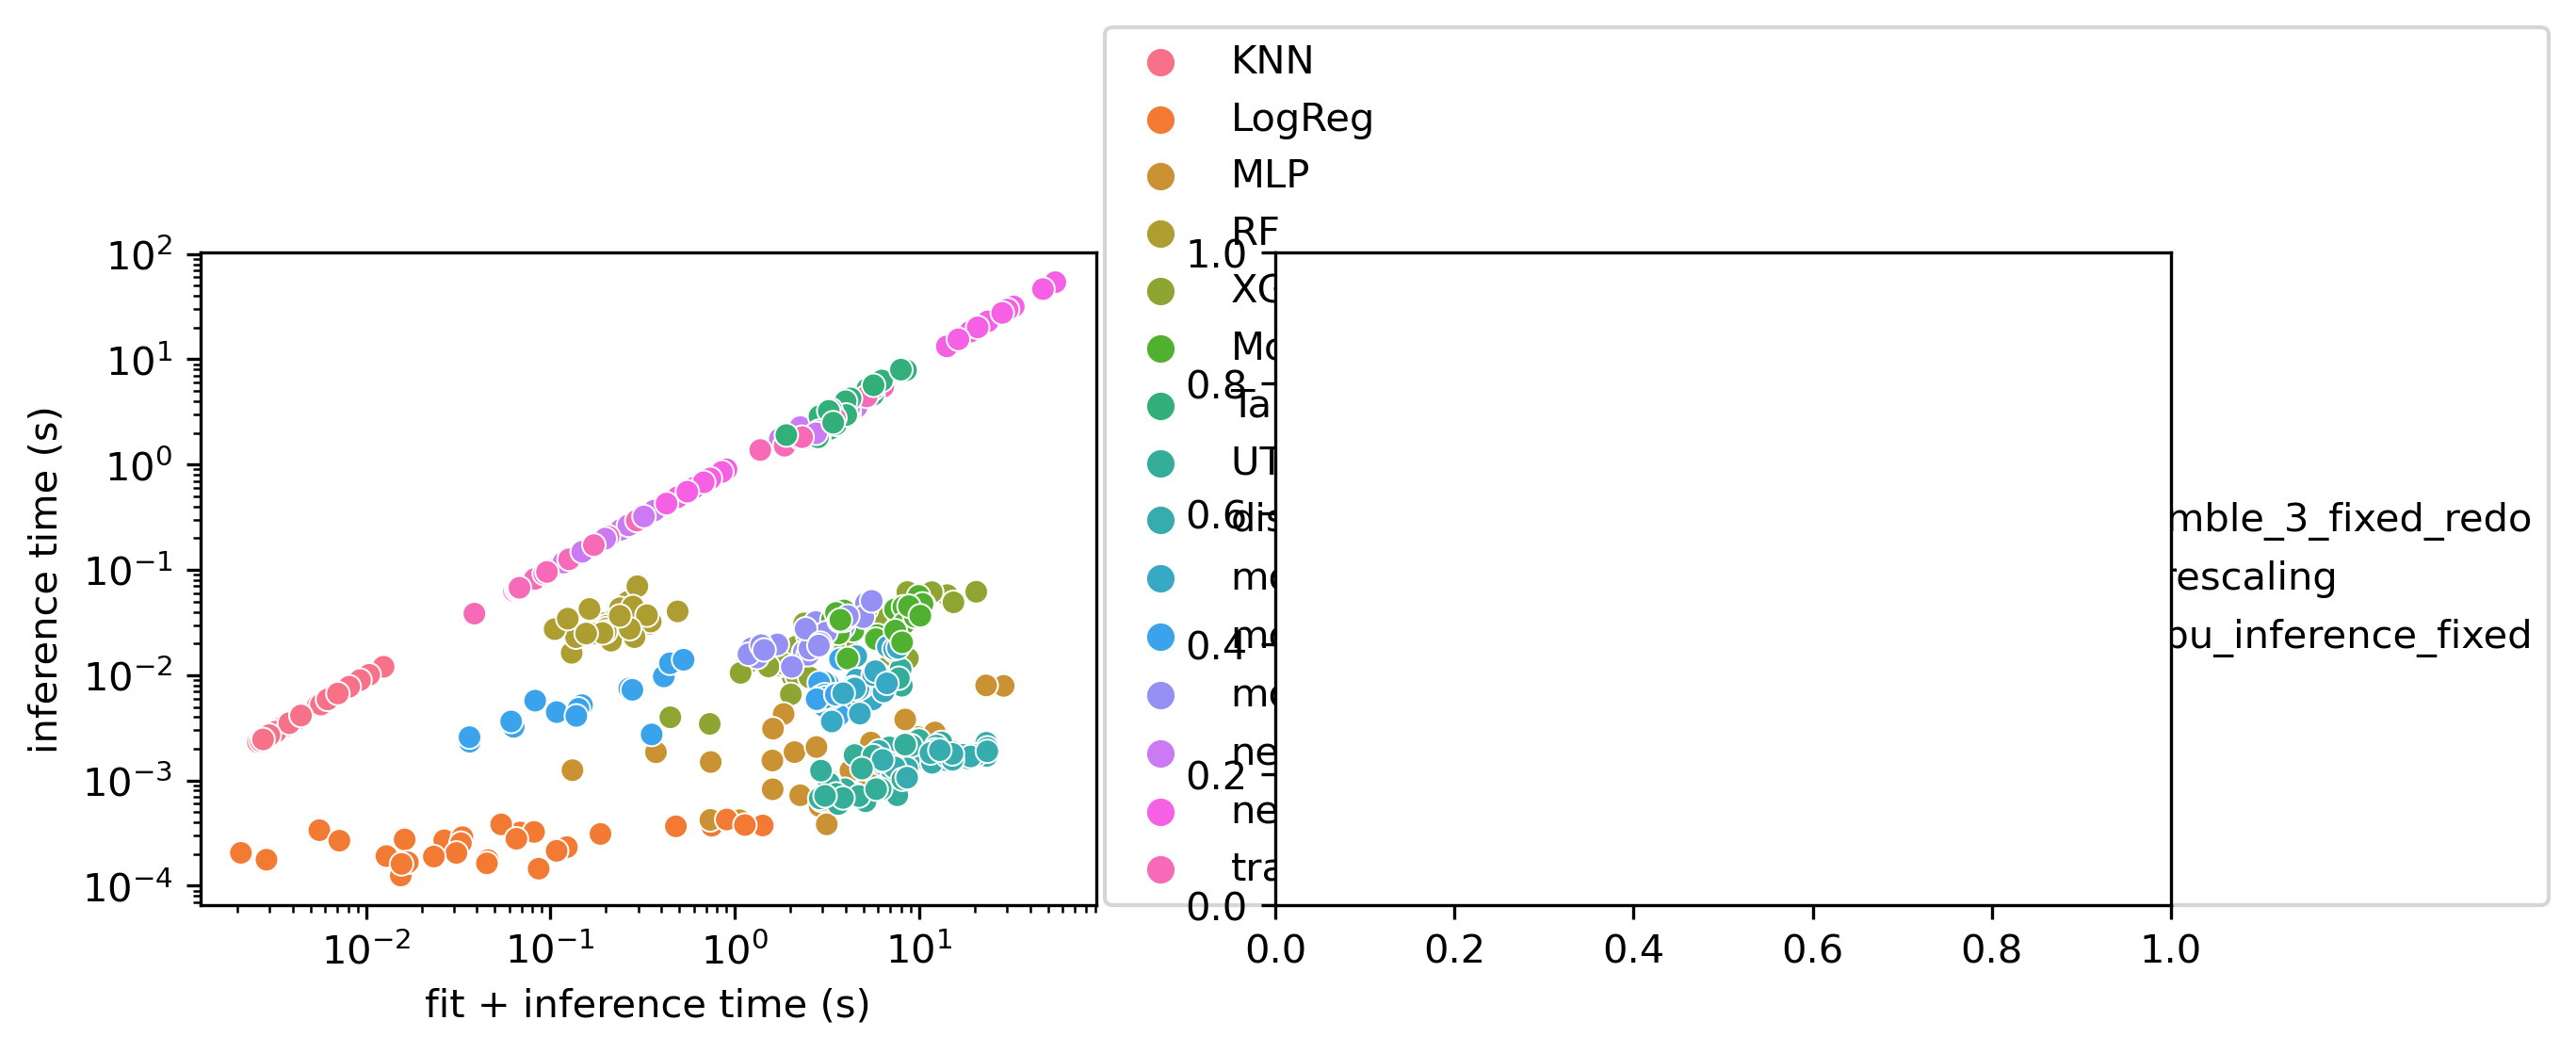

In [109]:

combined_best = pd.concat([best_tuned, untuned])
combined_best = combined_best[~combined_best.model.isin(["tabpfn_post_mlflow", "distill_tabpfn_scaled"])].copy()
max_time = combined_best.max_time.max()

fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=300)

combined_best['fit_and_predict_time'] = combined_best['fit_time'] + combined_best['inference_time']

#sns.scatterplot(data=combined_best, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[0], hue_order=["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU', "KNN", "LogReg", "RF", "MLP"])
sns.scatterplot(data=combined_best, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[0])
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("fit + inference time (s)")
axes[0].set_ylabel("inference time (s)")
legend = axes[0].legend(loc=(1.01, 0))
#sns.move_legend(axes[0], (1.01, 0))

combined_best['fit_predict_tuning'] = combined_best['fit_and_predict_time'].copy()
#with_tuning = with_tuning[with_tuning.model.isin(["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU'])]
combined_best.fit_predict_tuning[with_tuning.model == "XGBoost"] = combined_best.fit_and_predict_time[with_tuning.model == "XGBoost"] + 30
combined_best.fit_predict_tuning[with_tuning.model == "MLP"] = combined_best.fit_and_predict_time[with_tuning.model == "MLP"] + 5 * 60
combined_best.fit_predict_tuning[with_tuning.model == "KNN"] = combined_best.fit_and_predict_time[with_tuning.model == "KNN"] + max_time
combined_best.fit_predict_tuning[with_tuning.model == "RF"] = combined_best.fit_and_predict_time[with_tuning.model == "RF"] + max_time
combined_best.fit_predict_tuning[with_tuning.model == "LogReg"] = combined_best.fit_and_predict_time[with_tuning.model == "LogReg"] + 15


#sns.scatterplot(data=with_tuning, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[1], hue_order=["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU'])
sns.scatterplot(data=combined_best, y="inference_time", x="fit_predict_tuning", hue="model", ax=axes[1])
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("fit + inference time + tuning (s)")
axes[1].set_ylabel("inference time (s)")

axes[1].legend().remove()
plt.tight_layout()
plt.savefig("timing_comparison_two_panels_test.pdf")

In [ ]:
combined_best.set_index(['dataset', 'model']).unstack("model").fit_and_predict_time

In [ ]:
combined_best.set_index(['dataset', 'model']).unstack("model").fit_predict_tuning

In [ ]:
inference_time = combined_best.set_index(['dataset', 'model']).unstack("model").inference_time
inference_time_speedup = (inference_time.divide(inference_time['XGBoost'], axis='rows') ** -1).mean()

fit_and_predict_time = combined_best.set_index(['dataset', 'model']).unstack("model").fit_and_predict_time
fit_predict_speedup = (fit_and_predict_time.divide(fit_and_predict_time['XGBoost'], axis='rows') ** -1).mean()

fit_predict_tuning = combined_best.set_index(['dataset', 'model']).unstack("model").fit_predict_tuning
fit_predict_tuning_speedup = (fit_predict_tuning.divide(fit_predict_tuning['XGBoost'], axis='rows') ** -1).mean()


In [110]:
fit_and_predict_time.mean()

NameError: name 'fit_and_predict_time' is not defined

In [111]:
fit_predict_tuning

NameError: name 'fit_predict_tuning' is not defined

In [112]:
with pd.option_context("display.float_format", lambda x: f"{x:.1f}"):
    display(pd.DataFrame({'predict':inference_time_speedup, 'fit+predict': fit_predict_speedup, 'fit+predict+tuning': fit_predict_tuning_speedup}).T)

NameError: name 'inference_time_speedup' is not defined

In [113]:
with pd.option_context("display.float_format", lambda x: f"{x:.1f}"):
    print(pd.DataFrame({'predict':inference_time_speedup, 'fit+predict': fit_predict_speedup, 'fit+predict+tuning': fit_predict_tuning_speedup}).T.to_latex())

NameError: name 'inference_time_speedup' is not defined

In [114]:
with pd.option_context("display.float_format", lambda x: f"{x:.2f}"):
    print(pd.DataFrame({'predict':inference_time_speedup, 'fit+predict': fit_predict_speedup, 'fit+predict+tuning': fit_predict_tuning_speedup}).to_latex())

NameError: name 'inference_time_speedup' is not defined

In [115]:
bla = results_df.groupby(["model", "dataset", "max_time"])['mean_metric'].mean().reset_index()

In [116]:
bla.model.unique()

array(['KNN', 'LogReg', 'MLP', 'MotherNet', 'RF', 'TabPFN (ours)',
       'UTC-Distill GPU', 'XGBoost',
       'distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed_redo',
       'mothernet_01_07_16_e1720_cpu_ensemble3_prescaling',
       'mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference_fixed',
       'mothernet_21_46_25_3940_ensemble3',
       'new_tabpfn_long_e1650_ensemble3',
       'new_tabpfn_long_e1650_ensemble32', 'transformer_gpu_timing'],
      dtype=object)

In [173]:
filtered = bla[bla.model.isin(["TabPFN (ours)", "XGBoost", "MotherNet", "UTC-Distill GPU"])]

In [174]:
with_max_time = filtered.groupby(["model", "dataset"]).max().reset_index()

In [175]:
compare = with_max_time.pivot(index="dataset", columns="model", values="mean_metric")

In [176]:
len(compare)

30

In [196]:
different = compare[np.abs((compare['UTC-Distill GPU'] - compare["MotherNet"])) > 0.01]

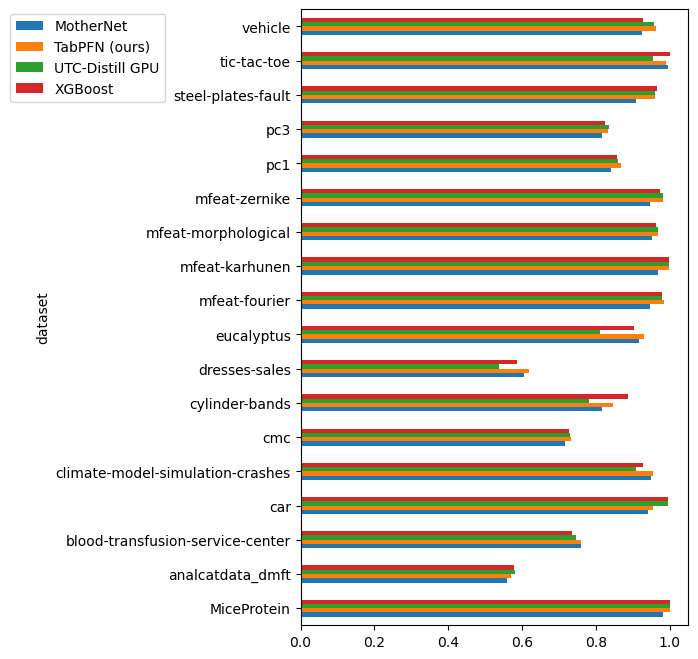

Bad pipe message: %s [b']{[-\xa9\xe1\x1e\x1c%-p_5p\xa5h[b \x1a\x0b\xbb.', b'\xf5\x90\xceT\xc2#^\xac\r\xc9*\xd2\xee\x8du\x82\xda\x84k\x1a\xca\x9a\xd6\xab\xa1\x82\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t', b'\x08\x0b\x08\x04\x08\x05\x08']
Bad pipe message: %s [b'\x01\x05\x01\x06\x01']
Bad pipe message: %s [b"\xc1\xd3\x05y\xa8\xefV)\xbc&\x1f\x8e\xed\x0b\xd2w\xd2\xde\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99

In [228]:
plt.figure(figsize=(5, 8))
different.plot.barh(ax=plt.gca())
plt.legend(loc=(-0.75 , .85))
plt.savefig("figures/test_set_differences.pdf", dpi=300, bbox_inches="tight")

In [123]:
cc_test_datasets_multiclass_df.set_index("name")

,did,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures,isNumeric
name,,,,,,,,,,,,,,,,
balance-scale,11,1,1,active,ARFF,288.0,3.0,49.0,3,5,625,0.0,0.0,4.0,1.0,True
mfeat-fourier,14,1,1,active,ARFF,200.0,10.0,200.0,10,77,2000,0.0,0.0,76.0,1.0,True
breast-w,15,1,1,active,ARFF,458.0,2.0,241.0,2,10,699,16.0,16.0,9.0,1.0,False
mfeat-karhunen,16,1,1,active,ARFF,200.0,10.0,200.0,10,65,2000,0.0,0.0,64.0,1.0,True
mfeat-morphological,18,1,1,active,ARFF,200.0,10.0,200.0,10,7,2000,0.0,0.0,6.0,1.0,True
mfeat-zernike,22,1,1,active,ARFF,200.0,10.0,200.0,10,48,2000,0.0,0.0,47.0,1.0,True
cmc,23,1,1,active,ARFF,629.0,4.0,333.0,3,10,1473,0.0,0.0,2.0,8.0,False
credit-approval,29,1,1,active,ARFF,383.0,14.0,307.0,2,16,690,37.0,67.0,6.0,10.0,False
credit-g,31,1,1,active,ARFF,700.0,10.0,300.0,2,21,1000,0.0,0.0,7.0,14.0,False


In [57]:
from sklearn.datasets import fetch_openml

In [62]:
cylinder_bands = fetch_openml(data_id=6332).frame

In [63]:
cylinder_bands

,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,direct_steam,...,solvent_pct,ESA_Voltage,ESA_Amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content,band_type
0,tvguide,25503.0,yes,key,yes,benton,gallatin,uncoated,uncoated,no,...,36.4,0.0,0.0,2.5,1.0,34.0,40,105.00,100,band
1,tvguide,25503.0,yes,key,yes,benton,gallatin,uncoated,uncoated,no,...,38.5,0.0,0.0,2.5,0.7,34.0,40,105.00,100,noband
2,modmat,47201.0,yes,key,yes,benton,gallatin,uncoated,coated,no,...,39.8,0.0,0.0,2.8,0.9,40.0,40,103.87,100,noband
3,massey,39039.0,yes,key,yes,benton,gallatin,uncoated,uncoated,no,...,38.8,0.0,0.0,2.5,1.3,40.0,40,108.06,100,noband
4,kmart,37351.0,no,key,yes,benton,gallatin,uncoated,coated,no,...,42.5,5.0,0.0,2.3,0.6,35.0,40,106.67,100,noband
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,kmart,85813.0,NaN,key,NaN,NaN,gallatin,super,uncoated,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,40,112.50,100,band
536,best,38064.0,NaN,key,NaN,NaN,gallatin,super,coated,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,40,110.00,100,band
537,kmart,85814.0,NaN,key,NaN,NaN,gallatin,super,coated,NaN,...,NaN,NaN,NaN,2.7,2.8,NaN,40,108.00,100,band
538,kmart,85814.0,NaN,key,NaN,NaN,gallatin,super,uncoated,NaN,...,NaN,NaN,NaN,1.5,2.3,NaN,40,108.00,100,band


In [64]:
asdf = fetch_openml(data_id=6332)

In [66]:
asdf.target_names

['band_type']

In [68]:
cylinder_bands.groupby("job_number").band_type.value_counts().unstack()

,band,noband
job_number,,
23040.0,1,0
23048.0,0,2
23050.0,0,2
23052.0,1,0
23055.0,1,0
...,...,...
85741.0,1,0
85750.0,1,0
85813.0,3,0


In [70]:
tictactoe =  fetch_openml(data_id=50)

In [71]:
tictactoe.frame.columns

Index(['top-left-square', 'top-middle-square', 'top-right-square',
       'middle-left-square', 'middle-middle-square', 'middle-right-square',
       'bottom-left-square', 'bottom-middle-square', 'bottom-right-square',
       'Class'],
      dtype='object')

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
ohe = OneHotEncoder(sparse=False)
X_train, X_test, y_train, y_test = train_test_split(ohe.fit_transform(tictactoe.data), tictactoe.target)

In [83]:
rf = RandomForestClassifier().fit(X_train, y_train)

In [85]:
rf.score(X_test, y_test)

0.9875

<AxesSubplot:>

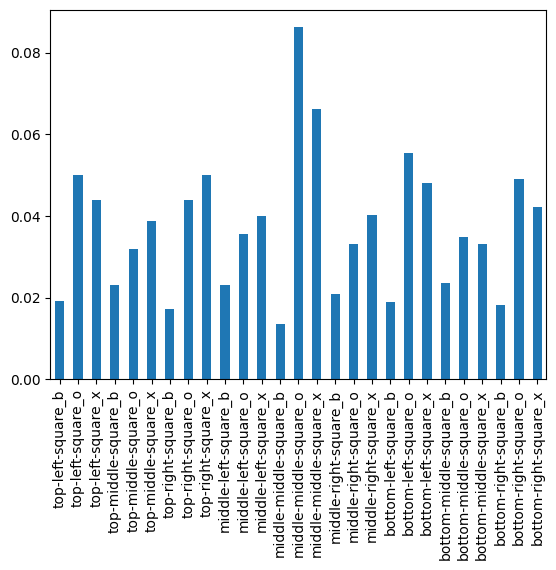

In [89]:
pd.Series(rf.feature_importances_, index=ohe.get_feature_names_out()).plot(kind="bar")